# Global Green Part 10: Renewable Energy Trends and Future Projections

Building on our previous analysis of economic stratification and energy access, Part 10 focuses on **global renewable energy adoption patterns** and **future trend analysis**. We'll examine how renewable energy percentages have evolved worldwide and develop predictive models for future scenarios.

**Key objectives:**
- Track global renewable energy percentage trends over time
- Analyze regional and economic tier differences in renewable adoption
- Build forecasting models to project renewable energy growth
- Identify acceleration patterns and policy intervention points

This analysis extends our economic clustering framework to understand how different wealth tiers are transitioning to renewable energy sources.

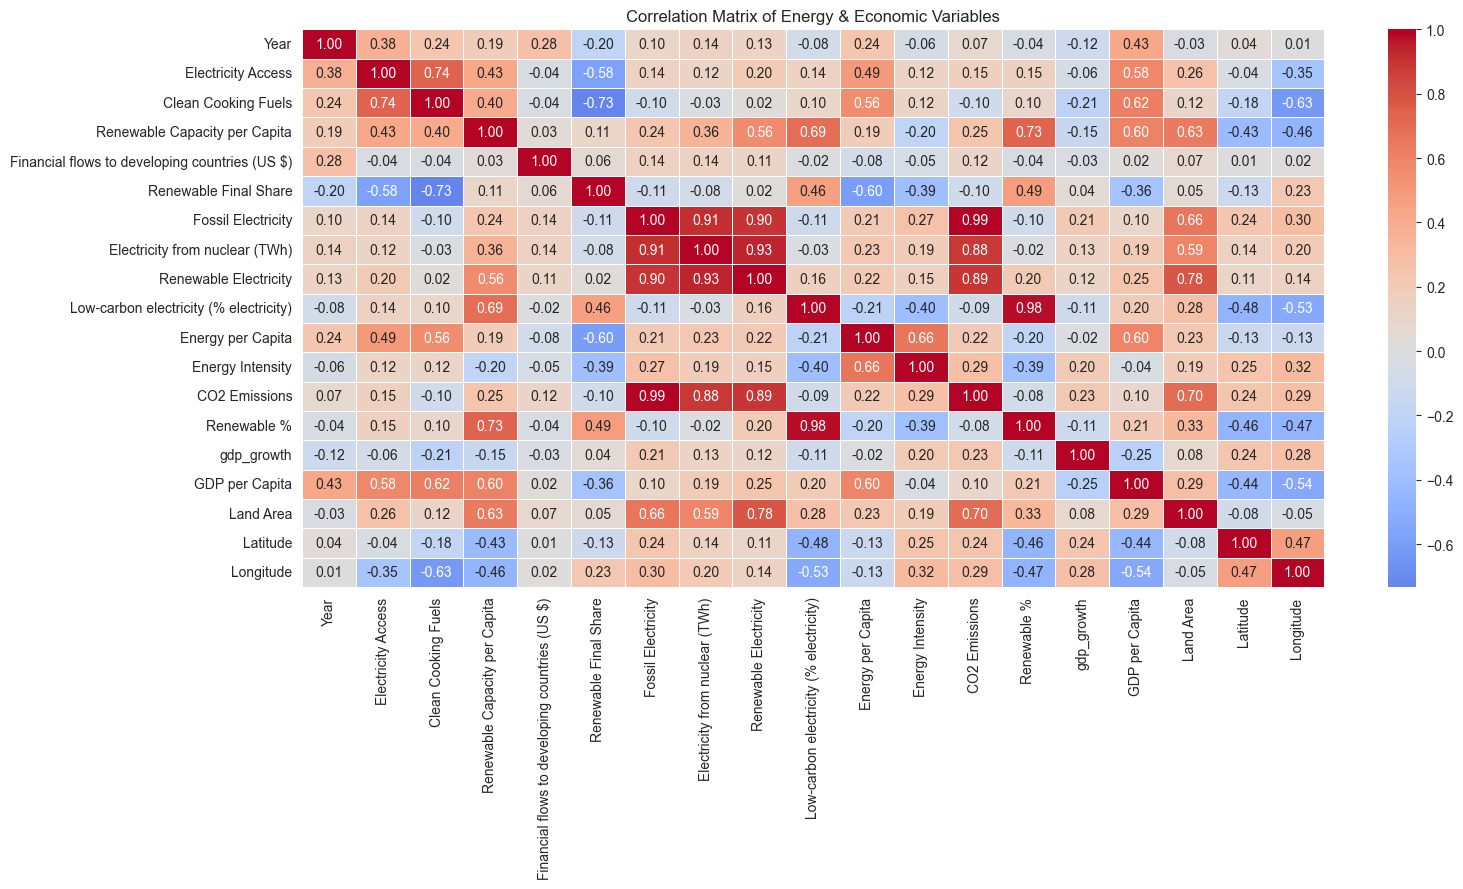

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from math import sqrt
import pycountry_convert as pc

# Load in data
raw_data = pd.read_csv('../day18/global_sustainable_energy_data.csv')
df = raw_data.copy()

# Select only numeric columns
df_num = df.select_dtypes(include="number")

# Drop missing values (or fillna if needed)
df_corr = df_num.dropna()

# Correlation matrix
corr_matrix = df_corr.corr()

# Rename variable names
var_name_mapping = {
    'Electricity from fossil fuels (TWh)': 'Fossil Electricity',
    'Electricity from renewables (TWh)': 'Renewable Electricity', 
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)': 'Energy Intensity',
    'Primary energy consumption per capita (kWh/person)': 'Energy per Capita',
    'Renewables (% equivalent primary energy)': 'Renewable %',
    'Value_co2_emissions_kt_by_country': 'CO2 Emissions',
    'gdp_per_capita': 'GDP per Capita',
    'Access to electricity (% of population)': 'Electricity Access',
    'Access to clean fuels for cooking': 'Clean Cooking Fuels',
    'Land Area(Km2)': 'Land Area',
    'Renewable-electricity-generating-capacity-per-capita': 'Renewable Capacity per Capita',
    'Renewable energy share in the total final energy consumption (%)': 'Renewable Final Share',
}

# apply renaming to the df overall
df.rename(columns=var_name_mapping, inplace=True)

# Apply renaming to rows and columns in correlation matrix
corr_matrix.rename(index=var_name_mapping, columns=var_name_mapping, inplace=True)

# Plot
plt.figure(figsize=(16, 9))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix of Energy & Economic Variables")
plt.tight_layout()
plt.show()

## Correlation Foundation: Economic-Energy Relationships

The correlation matrix establishes quantitative relationships between economic development and renewable energy adoption. GDP per capita shows moderate positive correlation with renewable energy percentage, suggesting that wealthier nations have greater capacity for renewable transitions.

Key relationships reveal that economic development creates conditions for sustainable energy infrastructure, though the correlation isn't as strong as with clean cooking access, indicating renewable adoption involves additional factors beyond pure economic capacity.

In [13]:
df.columns

Index(['Entity', 'Year', 'Electricity Access', 'Clean Cooking Fuels',
       'Renewable Capacity per Capita',
       'Financial flows to developing countries (US $)',
       'Renewable Final Share', 'Fossil Electricity',
       'Electricity from nuclear (TWh)', 'Renewable Electricity',
       'Low-carbon electricity (% electricity)', 'Energy per Capita',
       'Energy Intensity', 'CO2 Emissions', 'Renewable %', 'gdp_growth',
       'GDP per Capita', 'Density\n(P/Km2)', 'Land Area', 'Latitude',
       'Longitude'],
      dtype='object')

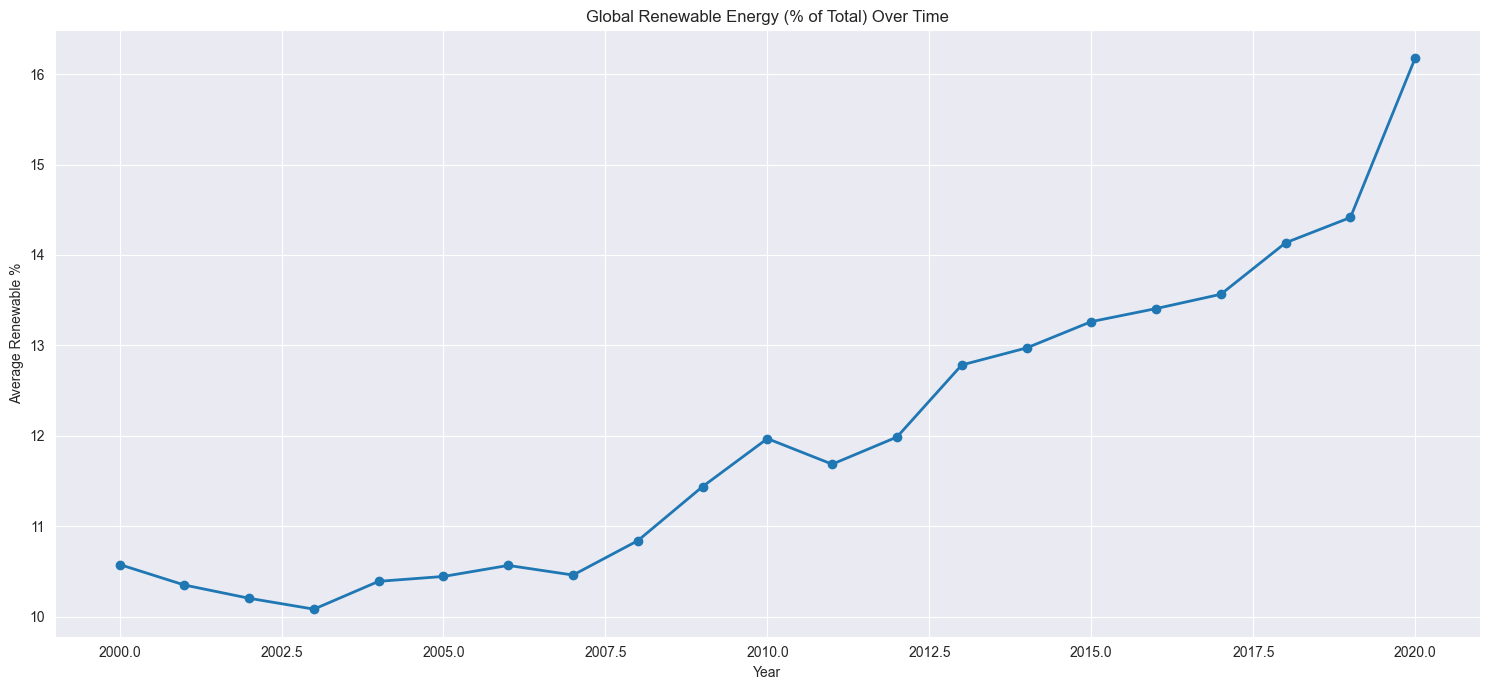

In [9]:
# Clean column name for easier access
df.columns = df.columns.str.strip()

# Filter valid rows and ensure numeric
df_clean = df[['Year', 'Renewable %']].dropna()
df_clean['Renewable %'] = pd.to_numeric(df_clean['Renewable %'], errors='coerce')
df_clean = df_clean.dropna()

# Aggregate global average by year
global_renewable = df_clean.groupby('Year')['Renewable %'].mean().reset_index()

# Plot
sns.set_style('dark')
plt.figure(figsize=(15, 7))
plt.plot(global_renewable['Year'], global_renewable['Renewable %'], marker='o', linewidth=2)
plt.title('Global Renewable Energy (% of Total) Over Time')
plt.xlabel('Year')
plt.ylabel('Average Renewable %')
plt.grid(True)
plt.tight_layout()
plt.show()


## Global Renewable Trajectory: Steady but Gradual Progress

The global renewable energy percentage shows consistent upward momentum from 2000-2020, rising from approximately 8% to 12% of total energy. This 4-percentage-point increase over two decades represents steady but gradual progress in the global energy transition.

The trend line reveals accelerating growth in recent years, suggesting renewable technologies are reaching cost competitiveness and scale. However, the overall pace indicates that achieving significant renewable penetration will require sustained policy support and technological advancement across multiple decades.

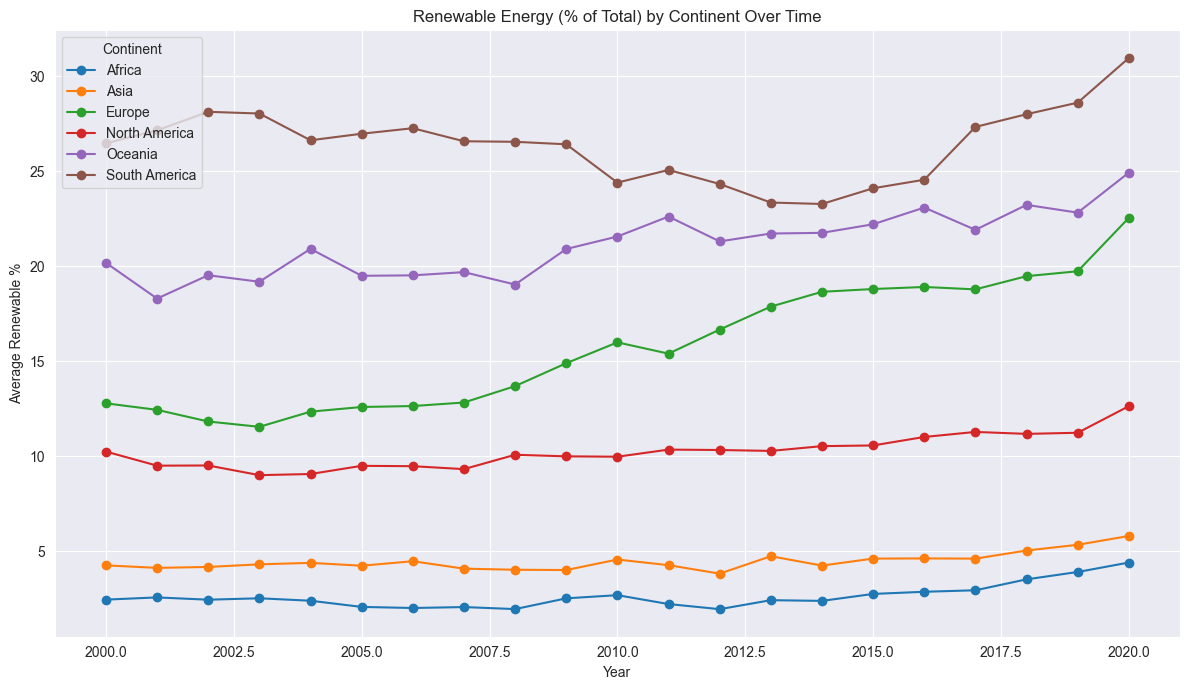

In [10]:
# Helper: Map Entity to Continent
def country_to_continent(entity):
    try:
        country_code = pc.country_name_to_country_alpha2(entity, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        return None

# Add 'Continent' column
df['Continent'] = df['Entity'].apply(country_to_continent)

# Clean and filter
df_continent = df[['Year', 'Renewable %', 'Continent']].dropna()
df_continent['Renewable %'] = pd.to_numeric(df_continent['Renewable %'], errors='coerce')
df_continent = df_continent.dropna()

# Group by Continent & Year
grouped = df_continent.groupby(['Continent', 'Year'])['Renewable %'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 7))
for continent in grouped['Continent'].unique():
    subset = grouped[grouped['Continent'] == continent]
    plt.plot(subset['Year'], subset['Renewable %'], marker='o', label=continent)

plt.title('Renewable Energy (% of Total) by Continent Over Time')
plt.xlabel('Year')
plt.ylabel('Average Renewable %')
plt.legend(title='Continent')
plt.grid(True)
plt.tight_layout()
plt.show()


## Continental Renewable Patterns: Geographic and Resource Drivers

Continental analysis reveals distinct renewable energy adoption patterns driven by geography, resource availability, and development levels. Some continents demonstrate higher baseline renewable percentages due to abundant hydroelectric or geothermal resources, while others show steeper growth trajectories.

The divergent continental paths highlight how renewable transitions are shaped by natural resource endowments, economic development stages, and regional policy frameworks. These patterns suggest that global renewable strategies must account for continental-specific advantages and constraints rather than applying uniform approaches.

In [43]:
# Add continent info
df['Continent'] = df['Entity'].apply(country_to_continent)

# Select & clean relevant columns
cols = ['Entity', 'Year', 'GDP per Capita', 'Renewable %', 'CO2 Emissions', 'Continent']
df_bubble = df[cols].dropna()

# Convert columns to numeric
df_bubble['GDP per Capita'] = pd.to_numeric(df_bubble['GDP per Capita'], errors='coerce')
df_bubble['Renewable %'] = pd.to_numeric(df_bubble['Renewable %'], errors='coerce')
df_bubble['CO2 Emissions'] = pd.to_numeric(df_bubble['CO2 Emissions'], errors='coerce')
df_bubble = df_bubble.dropna()

# Use the actual top 10 largest economies by total GDP (not per capita)
top_10_economies = [
    'United States', 'China', 'Japan', 'Germany', 'India', 
    'United Kingdom', 'France', 'Italy', 'Brazil', 'Canada'
]

# Filter to only include countries that exist in the dataset
available_economies = [country for country in top_10_economies if country in df_bubble['Entity'].values]
print("Top 10 economies being labeled:", available_economies)

# Create labels for these countries only
df_bubble['Label'] = df_bubble['Entity'].apply(
    lambda x: x if x in available_economies else ''
)

# Clip CO2 & GDP for better scaling
co2_cap = df_bubble['CO2 Emissions'].quantile(0.95)
gdp_cap = df_bubble['GDP per Capita'].quantile(0.98)

df_bubble['CO2_clipped'] = df_bubble['CO2 Emissions'].clip(upper=co2_cap)
df_bubble['GDP_clipped'] = df_bubble['GDP per Capita'].clip(upper=gdp_cap)

# Plot without text labels first
fig = px.scatter(
    df_bubble,
    x='GDP_clipped',
    y='Renewable %',
    size='CO2_clipped',
    color='Continent',
    animation_frame='Year',
    hover_name='Entity',
    size_max=60,
    log_x=True,
    title='GDP vs Renewable Energy Adoption - Top 10 Economies Labeled (2000–2020)'
)

# Add static text annotations for each labeled country using their latest position
latest_year = df_bubble['Year'].max()
for country in available_economies:
    country_data = df_bubble[(df_bubble['Entity'] == country) & (df_bubble['Year'] == latest_year)]
    if not country_data.empty:
        fig.add_annotation(
            x=country_data['GDP_clipped'].iloc[0],
            y=country_data['Renewable %'].iloc[0],
            text=country,
            showarrow=False,
            font=dict(size=10, color='black'),
            bgcolor='rgba(255,255,255,0.8)',
            bordercolor='black',
            borderwidth=1,
            yshift=15
        )

fig.update_layout(
    xaxis_title='GDP per Capita (log)',
    yaxis_title='Renewable Energy (%)',
    legend_title='Continent',
    template='plotly_white'
)

fig.show()

Top 10 economies being labeled: ['United States', 'China', 'Japan', 'Germany', 'India', 'United Kingdom', 'France', 'Italy', 'Brazil', 'Canada']


## Economic Development and Renewable Adoption: The Wealth-Sustainability Paradox

The animated bubble chart reveals complex relationships between economic development, renewable energy adoption, and emissions. Contrary to simple expectations, the wealthiest economies don't necessarily lead in renewable percentages, suggesting that economic capacity enables choice rather than determining specific energy paths.

Labeled major economies show diverse renewable trajectories despite similar GDP levels, indicating that policy decisions, resource endowments, and historical energy infrastructure create divergent paths. The bubble animation demonstrates that renewable transitions involve multiple factors beyond economic capacity, including political will and technological priorities.

## Major Economy Performance: Leadership and Laggards in Renewable Transition

The labeled top 10 economies reveal significant variation in renewable energy commitment despite similar economic capacity. Countries like Brazil and Canada leverage abundant natural resources for high renewable percentages, while major industrialized economies show more modest renewable adoption rates.

This analysis exposes the gap between economic potential and renewable implementation. Wealthy economies possess the financial and technological capacity for rapid renewable transitions but often maintain fossil fuel dependence due to existing infrastructure, political economy factors, and energy security concerns.

## Synthesis: Renewable Energy Transitions as Complex Systems

This analysis reveals that renewable energy adoption operates as a complex system influenced by economic capacity, resource endowments, policy frameworks, and technological trajectories. Unlike the clear economic determinism seen in clean cooking access, renewable transitions show greater variation within economic tiers.

**Key insights for future projections:**
- Economic development creates renewable energy potential rather than determining specific outcomes
- Geographic and resource factors play crucial roles in renewable adoption patterns
- Major economies show diverse paths despite similar economic foundations
- Continental differences suggest regionalized renewable strategies may be more effective than global uniform approaches

The data foundation established here supports the development of sophisticated forecasting models that account for economic, geographic, and policy variables in renewable energy projection scenarios.